In [1]:
%store -r denver_redlining_gdf data_dir

Data already exists. No need to download.
<xarray.DataArray (band: 1, y: 447, x: 504)> Size: 901kB
[225288 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 4.947e+05 4.947e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 4kB 4.4e+06 4.4e+06 4.4e+06 ... 4.387e+06 4.387e+06
    spatial_ref  int64 8B 0
Attributes: (12/35)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    ULX:                       399960
    ULY:                       4400040
    USGS_SOFTWARE:             LPGS_16.3.0
    AREA_OR_POINT:             Area
    scale_factor:              0.0001
    add_offset:                0.0
<xarray.DataArray (band: 1, y: 447, x: 504)> Size: 901kB
[225288 values with dtype=float32]
Coordinates:
  * band         (b

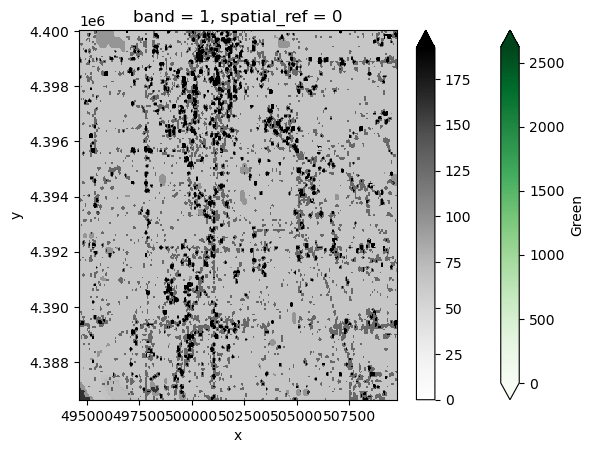

In [2]:
# Reproducible file paths
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
# Find files by pattern

import numpy as np # Unpack bit-wise Fmask
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
import os
from glob import glob

# Define the URL for the sample raster data
hls_url = (
    "https://github.com/cu-esiil-edu/esiil-learning-portal/releases"
    "/download/data-release/redlining-foundations-data.zip"
)

# Define the directory to save the raster data
hls_dir = os.path.join(data_dir, 'hls')
os.makedirs(hls_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Check if there are any .tif files in the directory
if not glob(os.path.join(hls_dir, '*.tif')):
    # Download the sample raster data from the URL
    hls_response = requests.get(hls_url)

    # Save and extract the raster data (uncompress the zip file)
    with zipfile.ZipFile(BytesIO(hls_response.content)) as hls_zip:
        hls_zip.extractall(hls_dir)

    print("Data downloaded and extracted successfully.")
else:
    print("Data already exists. No need to download.")
    
# Find the path to the green layer (Band 3, 0.53 – 0.59 micrometer)
green_path = glob(os.path.join(hls_dir, "*B03*.tif"))[0]  # Get the first match for the green band

# Open the green data in Python using rioxarray
green_da = rxr.open_rasterio(green_path, masked=True)

# Display the green band
print(green_da)  # Print details of the data array
green_da.plot(cmap='Greens', vmin=0, robust=True)

# Find the path to the cloud mask
cloud_path = glob(os.path.join(hls_dir, "*Fmask*.tif"))[0]  # Get the first match for the green band

# Open the cloud data in Python using rioxarray
cloud_da = rxr.open_rasterio(cloud_path, masked=True)

# Display the clouds
print(cloud_da)  # Print details of the data array
cloud_da.plot(cmap='Grays', vmin=0, robust=True)

# # Get the cloud mask as bits
# cloud_bits = (
#     np.unpackbits(
#         (
#             # Get the cloud mask as an array...
#             cloud_da.values
#             # ... of 8-bit integers
#             .astype('uint8')
#             # With an extra axis to unpack the bits into
#             [:, :, np.newaxis]
#         ), 
#         # List the least significat bit first to match the user guide
#         bitorder='little',
#         # Expand the array in a new dimension
#         axis=-1)
# )

# # Select only the bits we want to mask
# bits_to_mask = [
#     1, # Cloud
#     2, # Adjacent to cloud
#     3, # Cloud shadow
#     5] # Water
# # And add up the bits for each pixel
# cloud_mask = np.sum(
#     # Select bits 
#     cloud_bits[:,:,bits_to_mask], 
#     # Sum along the bit axis
#     axis=-1
# )

# # Mask the pixel if the sum is greater than 0
# # (If any of the bits are True)
# cloud_mask = cloud_mask == 0
# cloud_mask
# Get the cloud mask data as an array of 8-bit integers
cloud_values = cloud_da.values  # Get cloud data as numpy array

# Check the shape of the cloud values array (should be (bands, rows, cols))
print("Shape of cloud_da.values:", cloud_values.shape)

# Unpack the bits, ensuring correct dimensionality
cloud_bits = np.unpackbits(
    cloud_values.astype('uint8'),  # Convert to 8-bit unsigned integers
    bitorder='little',  # Unpack bits with least significant bit first
    axis=-1  # Expand along a new dimension (last axis)
)

# Check the shape after unpacking
print("Shape of cloud_bits after unpacking:", cloud_bits.shape)

# Ensure the cloud_bits array has at least 3 dimensions
if cloud_bits.ndim < 3:
    cloud_bits = np.expand_dims(cloud_bits, axis=-1)  # Add new axis if needed

# Define the bits to mask (Cloud, Adjacent to cloud, Cloud shadow, Water)
bits_to_mask = [1, 2, 3, 5]

# Make sure the bits_to_mask exist within the cloud_bits shape
if cloud_bits.shape[-1] > max(bits_to_mask):
    # Sum over the selected bits in cloud_bits
    cloud_mask = np.sum(
        cloud_bits[..., bits_to_mask],  # Select bits along the last axis
        axis=-1  # Sum along the bit axis (collapse bits into one layer)
    ) == 0
else:
    raise IndexError(f"Selected bits {bits_to_mask} exceed the available bits in cloud_bits.")

# Display the cloud mask
print(cloud_mask)

# (Optional) Plot the cloud mask if using a library that supports it
# Example: matplotlib or xarray for plotting
# plt.imshow(cloud_mask, cmap='Grays')

In [3]:
# Get the cloud mask data as an array of 8-bit integers
cloud_values = cloud_da.values  # Get cloud data as numpy array

# Check the shape of the cloud values array (should be (bands, rows, cols))
print("Shape of cloud_da.values:", cloud_values.shape)

# Unpack the bits, ensuring correct dimensionality
cloud_bits = np.unpackbits(
    cloud_values.astype('uint8'),  # Convert to 8-bit unsigned integers
    bitorder='little',  # Unpack bits with least significant bit first
    axis=-1  # Expand along a new dimension (last axis)
)

# Check the shape after unpacking
print("Shape of cloud_bits after unpacking:", cloud_bits.shape)

# Ensure the cloud_bits array has at least 3 dimensions
if cloud_bits.ndim < 3:
    cloud_bits = np.expand_dims(cloud_bits, axis=-1)  # Add new axis if needed

# Define the bits to mask (Cloud, Adjacent to cloud, Cloud shadow, Water)
bits_to_mask = [1, 2, 3, 5]

# Make sure the bits_to_mask exist within the cloud_bits shape
if cloud_bits.shape[-1] > max(bits_to_mask):
    # Sum over the selected bits in cloud_bits
    cloud_mask = np.sum(
        cloud_bits[..., bits_to_mask],  # Select bits along the last axis
        axis=-1  # Sum along the bit axis (collapse bits into one layer)
    ) == 0
else:
    raise IndexError(f"Selected bits {bits_to_mask} exceed the available bits in cloud_bits.")

# Display the cloud mask
print(cloud_mask)

# (Optional) Plot the cloud mask if using a library that supports it
# Example: matplotlib or xarray for plotting
# plt.imshow(cloud_mask, cmap='Grays')

green_masked_da = green_da.where(cloud_mask, green_da.rio.nodata)
green_masked_da.plot(cmap='Greens', vmin=0, robust=True)

Shape of cloud_da.values: (1, 447, 504)
Shape of cloud_bits after unpacking: (1, 447, 4032)
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True 

ValueError: operands could not be broadcast together with shapes (1,447) (1,447,504) () 

In [ ]:
## this one was maybe causing a different size of array
# # cloud_bits = (
# #     np.unpackbits(
# #         (
# #             # Get the cloud mask as an array...
# #             cloud_da.values
# #             # ... of 8-bit integers
# #             .astype('uint8')
# #             # With an extra axis to unpack the bits into
# #             [:, :, np.newaxis]
# #         ), 
# #         # List the least significat bit first to match the user guide
# #         bitorder='little',
# #         # Expand the array in a new dimension
# #         axis=-1)
# # )

# # bits_to_mask = [
# #     1, # Cloud
# #     2, # Adjacent to cloud
# #     3, # Cloud shadow
# #     5] # Water

# # cloud_mask = np.sum(
# #     # Select bits 1, 2, and 3
# #     cloud_bits[:,:,bits_to_mask], 
# #     # Sum along the bit axis
# #     axis=-1

# # # Check if any of bits 1, 2, or 3 are true
# # ) == 0

# # cloud_mask

# #fixing for indexerror
# import numpy as np

# # Get the cloud mask data as an array of 8-bit integers
# cloud_bits = np.unpackbits(
#     cloud_da.values.astype('uint8'),  # Convert to 8-bit unsigned integers
#     bitorder='little',  # Unpack bits with least significant bit first
#     axis=-1  # Expand along a new dimension (last axis)
# )

# # Define the bits to mask (Cloud, Adjacent to cloud, Cloud shadow, Water)
# bits_to_mask = [1, 2, 3, 5]

# # Sum over the selected bits in cloud_bits
# # Check if any of bits 1, 2, or 3 are true (clouds, shadows, etc.)
# cloud_mask = np.sum(
#     cloud_bits[:, :, bits_to_mask],  # Select bits 1, 2, 3, 5 along last axis
#     axis=-1  # Sum along the bit axis (collapse bits into one layer)
# ) == 0

# # Display or return the cloud mask
# cloud_mask
# #this did not work cloud_mask.plot(cmap='Grays', vmin=0, robust=True)
# #numpy.ndarray object hat no attribute for plot

In [4]:
# Get the cloud mask as bits
cloud_bits = (
    np.unpackbits(
        (
            # Get the cloud mask as an array...
            cloud_da.values
            # ... of 8-bit integers
            .astype('uint8')
            # With an extra axis to unpack the bits into
            [:, :, np.newaxis]
        ), 
        # List the least significat bit first to match the user guide
        bitorder='little',
        # Expand the array in a new dimension
        axis=-1)
)

# Select only the bits we want to mask
bits_to_mask = [
    1, # Cloud
    2, # Adjacent to cloud
    3, # Cloud shadow
    5] # Water
# And add up the bits for each pixel
cloud_mask = np.sum(
    # Select bits 
    cloud_bits[:,:,bits_to_mask], 
    # Sum along the bit axis
    axis=-1
)

# Mask the pixel if the sum is greater than 0
# (If any of the bits are True)
cloud_mask = cloud_mask == 0
cloud_mask

IndexError: index 1 is out of bounds for axis 2 with size 1

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Apply the cloud mask</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the <code>.where()</code> method to remove all the pixels you
identified in the previous step from your green reflectance
<code>DataArray</code>.</li>
</ol></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load all bands</div></div><div class="callout-body-container callout-body"><p>The sample data comes with 15 different bands. Some of these are
spectral bands, while others are things like a cloud mask, or the angles
from which the image was taken. You only need the spectral bands.
Luckily, all the spectral bands have similar file names, so you can use
<strong>indices</strong> to extract which band is which from the
name:</p>
<ol type="1">
<li>Fill out the <code>bands</code> dictionary based on the User Guide.
You will use this to replace band numbers from the file name with
human-readable names.</li>
<li>Locate the position of the band id number in the file path. It is
easiest to do this from the end, with negative indices. Fill out the
<code>start_index</code> and <code>end_index</code> variables with the
position values. You might need to test this before moving on!</li>
<li>Add code to open up the band in the spot to save it to the
<code>band_dict</code></li>
</ol></div></div>

In [5]:
green_masked_da = green_da.where(cloud_mask, green_da.rio.nodata)
green_masked_da.plot(cmap='Greens', vmin=0, robust=True)

ValueError: operands could not be broadcast together with shapes (1,447) (1,447,504) () 

In [ ]:
# # updated combined to clean up the array info one attempt that did not work

# import numpy as np
# import rioxarray as rxr
# import os
# from glob import glob
# import xarray as xr

# # Find the path to the green layer (Band 3, 0.53 – 0.59 micrometer)
# green_path = glob(os.path.join(hls_dir, "*B03*.tif"))[0]  # Get the first match for the green band

# # Open the green data in Python using rioxarray
# green_da = rxr.open_rasterio(green_path, masked=True)

# # Unpack the cloud mask bits
# cloud_bits = np.unpackbits(
#     cloud_da.values.astype('uint8'),  # Convert to 8-bit unsigned integers
#     bitorder='little',  # Unpack bits with least significant bit first
#     axis=-1  # Expand along a new dimension (last axis)
# )

# # Define the bits to mask (Cloud, Adjacent to cloud, Cloud shadow, Water)
# bits_to_mask = [1, 2, 3, 5]

# # Create the cloud mask (Sum the relevant bits and check if any are true)
# cloud_mask_np = np.sum(cloud_bits[:, :, bits_to_mask], axis=-1) == 0

# # Convert cloud_mask_np to an xarray.DataArray with the same coordinates as green_da
# cloud_mask = xr.DataArray(
#     cloud_mask_np, 
#     dims=green_da.dims,  # Use the same dimensions as green_da (e.g., time, y, x)
#     coords=green_da.coords  # Use the same coordinates (lat, lon, time, etc.)
# )

# # Apply the cloud mask to the green data array
# green_masked_da = green_da.where(cloud_mask, green_da.rio.nodata)

# # Plot the masked green band
# green_masked_da.plot(cmap='Greens', vmin=0, robust=True)


In [6]:
# Define band labels
bands = {
    'B01': 'aerosol',
    ...
}

band_dict = {}
band_paths = glob(os.path.join(hls_dir, '*.tif'))
for band_path in band_paths:
    # Get the band number and name
    start_index = 
    end_index = 
    band_id = band_path[start_index:end_index]
    band_name = bands[band_id]

    # Open the band and accumulate
    band_dict[band_name] = 
band_dict

SyntaxError: ':' expected after dictionary key (633795929.py, line 4)

In [17]:
%store band_dict